# План
1. Графики: Определить общие детали исходных данных 

2. Чистка данных \
2.1. Outliers: посмотреть на выбросы и решить, что с ними делать \
2.2. Ошибки в данных: исправление NaN и возможных ошибок \
**Результат** - модуль features c препроцессингом и генерацией некоторых признаков

3. Анализ: поиск зависимостей в данных с исправлениями

4. Поиск класса людей, которым требуется коммуникация: поможем модели определить самых необходимую группу данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn import linear_model, metrics, preprocessing
from sklearn.model_selection import KFold, train_test_split
import xgboost

import azureml.core
from azureml.core import Dataset
from azureml.core.authentication import InteractiveLoginAuthentication
from azureml.core import Experiment, Workspace

import sys
sys.path.append('../')
sys.path.append('../scripts/')

In [2]:
# Log In to Azure ML Workspace
interactive_auth = InteractiveLoginAuthentication(tenant_id="76f90eb1-fb9a-4446-9875-4d323d6455ad")

# Initialise workspace
ws = Workspace.from_config(auth=interactive_auth)

# Data import 
aml_dataset = Dataset.get_by_name(ws, 'train_ds', version='latest')
data = aml_dataset.to_pandas_dataframe()
data.set_index('CardHolder', inplace=True)

# Save it to the further opeartions
original_columns = data.columns
data_origin = data.copy()

/anaconda/envs/py37_default/lib/python3.7/site-packages/azureml/dataprep/api/dataflow.py:722: UserWarning: Your pandas and pyarrow versions are incompatible. Please install pyarrow>=0.12.0 for improved performance of to_pandas_dataframe. You can ensure the correct version is installed by running: pip install pyarrow>=0.12.0 --upgrade
  warnings.warn('Your pandas and pyarrow versions are incompatible. '


In [38]:
# Checkpoint
data = data_origin.copy()

# 1. Графики

In [173]:
def separation_scatter(data_input, columnx, columny, dropx=False, dropy=False):
    data = data_input.copy()
    
    data_mask = np.array([True]*data[columnx].shape[0])
    if (dropx):
        values = data[columnx]
        IQR = values.quantile(0.75) - values.quantile(0.25)
        data_mask = data_mask & (values <= values.quantile(0.75) + IQR * 1.5).values
        
    if (dropy):
        values = data[columny]
        IQR = values.quantile(0.75) - values.quantile(0.25)
        data_mask = data_mask & (values <= values.quantile(0.75) + IQR * 1.5).values
                         
    data = data.loc[data_mask]
    
    fig, ax = plt.subplots(2, 2, figsize=(18, 10))
    plt.title('Признаки: {}, {}'.format(columnx, columny))

    # Data separation (parametres are explicit)
    stubborn = data[data['group'] == 'test']
    stubborn = stubborn[stubborn['response_att'] == 0]

    active = data[data['group'] == 'test']
    active = active[active['response_att'] == 1]

    ax = plt.subplot(221)
    sample = stubborn
    sns.scatterplot(sample[columnx], sample[columny])
    plt.title('Участники тестовой группы, которые не пошли на акцию')
    ax.set_xlabel(columnx)

    plt.subplot(223)
    plt.hist(sample[columny])

    ax = plt.subplot(222)
    sample = active
    sns.scatterplot(sample[columnx], sample[columny])
    plt.title('Участники тестовой группы, которые пошли на акцию')
    ax.set_xlabel(columnx)

    plt.subplot(224)
    plt.hist(sample[columny])

    plt.show()

In [142]:
def class_separator(data):
    s11 = (data['group'] == 'test').values & (data['response_att'] == 1).values
    s10 = (data['group'] == 'test').values & (data['response_att'] == 0).values
    s01 = (data['group'] == 'control').values & (data['response_att'] == 1).values
    s00 = (data['group'] == 'control').values & (data['response_att'] == 0).values
    
    return s00, s01, s10, s11

def quantile_activeness_proportions(data, features_list, n_groups=20):
    fig, ax = plt.subplots(len(features_list)//2, 2, figsize=(18, 5*(len(features_list)//2)))
    fig.suptitle('Пропорция числа пришедших к числу непришедших в промежуктах квантилей по разным признакам')

    s00, s01, s10, s11 = class_separator(data)
    format1_mask = (data['main_format'] == 1).values
    format0_mask = (data['main_format'] == 0).values

    for j in range(len(features_list)):
        key = features_list[j]

        sp_control = []
        sp_test = []

        sp_control_big = []
        sp_test_big = []
        for i in range(n_groups):
            data_sample = (data[key] >= data[key].quantile(i * (1 / n_groups))).values & \
                (data[key] <= data[key].quantile((i + 1) * (1 / n_groups))).values

            data_little_shops = format1_mask & data_sample
            data_big_shops = format0_mask & data_sample

            sp_control.append((s01 & data_little_shops).sum() / (s00 & data_little_shops).sum())
            sp_test.append((s11 & data_little_shops).sum() / (s10 & data_little_shops).sum())

            sp_control_big.append((s01 & data_big_shops).sum() / (s00 & data_big_shops).sum())
            sp_test_big.append((s11 & data_big_shops).sum() / (s10 & data_big_shops).sum())

        ax[j//2, j%2].set_xlabel("Квантиль")
        ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_control)
        ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_test)
        ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_control_big)
        ax[j//2, j%2].plot([(i + 1) * (1 / n_groups) for i in range(n_groups)], sp_test_big)

        ax[j//2, j%2].legend(['Пропорция в контрольной выборке', 'Пропорция в тестовой выборке', 
                             'Пропорция в контрольной выборке (гипермаркеты)', 'Пропорция в тестовой выборке (гипермаркеты)'])
        ax[j//2, j%2].set_title(key)

    plt.show()

In [73]:
def check_element(data, column, element):
    val_count = (data_origin['stdev_days_between_visits_15d'] == 0).value_counts()
    print("Этот элемент встречается в {}% записей колонки {}".format(100 * val_count[True] / data.shape[0], column))

In [74]:
check_element(data, 'stdev_days_between_visits_15d', 0)

Этот элемент встречается в 76.526755056919% записей колонки stdev_days_between_visits_15d


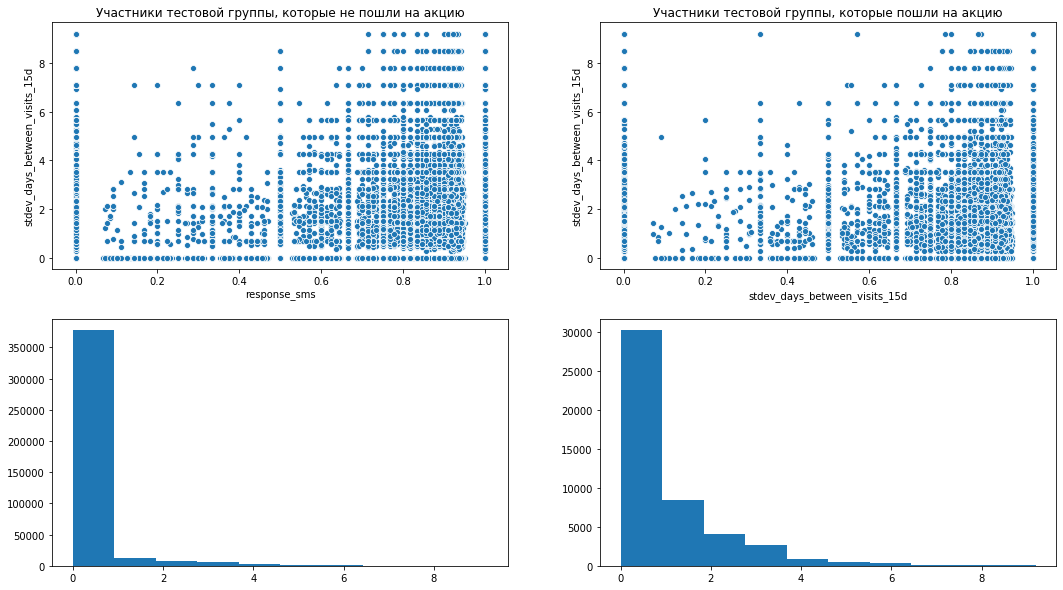

In [50]:
separation_scatter(data, 'response_sms', 'stdev_days_between_visits_15d')

In [75]:
# Any group number is in diaposon from 20 to 79
all_groups = [i for i in range(20, 80)]

# This function returns columns from 'columns' list, which are met in columns of "data"
def get_columns_list(data, columns):
    return data.columns[data.columns.isin(columns)]

In [167]:
# Checkpoint
data = data_origin.copy()

# Name of a feature : (columns to collect from, method)
# methods : mean, max, min, sum
collect_features = {
    'disconut_std'  : (['promo_share_15d', 'mean_discount_depth_15d'], 'std'),
    'k_var_discount_depth_15d'  : (['response_sms', 'response_viber'], 'std'),
    'response_sms' : (),
    'response_viber' : (),
    'months_from_register' : ()
}

# Add collections
for key in collect_features.keys():
    if collect_features[key] == ():
        continue
    
    method = collect_features[key][1]
    
    if method == 'mean':
        data.loc[:, key] = data[collect_features[key][0]].mean(axis=1)
    elif method == 'sum':
        data.loc[:, key] = data[collect_features[key][0]].sum(axis=1)
    elif method == 'std':
        data.loc[:, key] = data[collect_features[key][0]].std(axis=1)
    elif method == 'max':
        data.loc[:, key] = data[collect_features[key][0]].max(axis=1)
    elif method == 'min':
        data.loc[:, key] = data[collect_features[key][0]].min(axis=1)
        
# Additional observations
add_features = ['stdev_discount_depth_15d/1m', 
                'k_var_discount_depth_15d/1m',
                'k_var_disc_1', 'k_var_disc_2', 'k_var_disc_3', 'k_var_disc_4'
               ]

data.loc[:, 'k_var_discount_depth_15d/1m'] = data['k_var_discount_depth_15d' ] / (data['k_var_discount_depth_1m'].fillna(0) + 1)
data.loc[:, 'k_var_disc_1'] = \
    data['k_var_disc_share_3m_g34'] * data['k_var_count_per_cheque_3m_g34']  / (data['k_var_sku_price_3m_g34'] + 1)
data.loc[:, 'k_var_disc_2'] = \
    data['k_var_disc_share_3m_g34'] * data['k_var_sku_price_3m_g34']  / (data['k_var_count_per_cheque_3m_g34'] + 1)
data.loc[:, 'k_var_disc_3'] = \
    data['k_var_disc_share_3m_g34'] * data['k_var_count_per_cheque_3m_g34'] * data['k_var_sku_price_3m_g34']
data.loc[:, 'k_var_disc_4'] = \
    data['k_var_count_per_cheque_3m_g34'] * data['k_var_sku_price_3m_g34']  / (data['k_var_disc_share_3m_g34'] + 1)

features_list = add_features + list(collect_features.keys()) 

/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_default/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars
/anaconda/envs/py37_

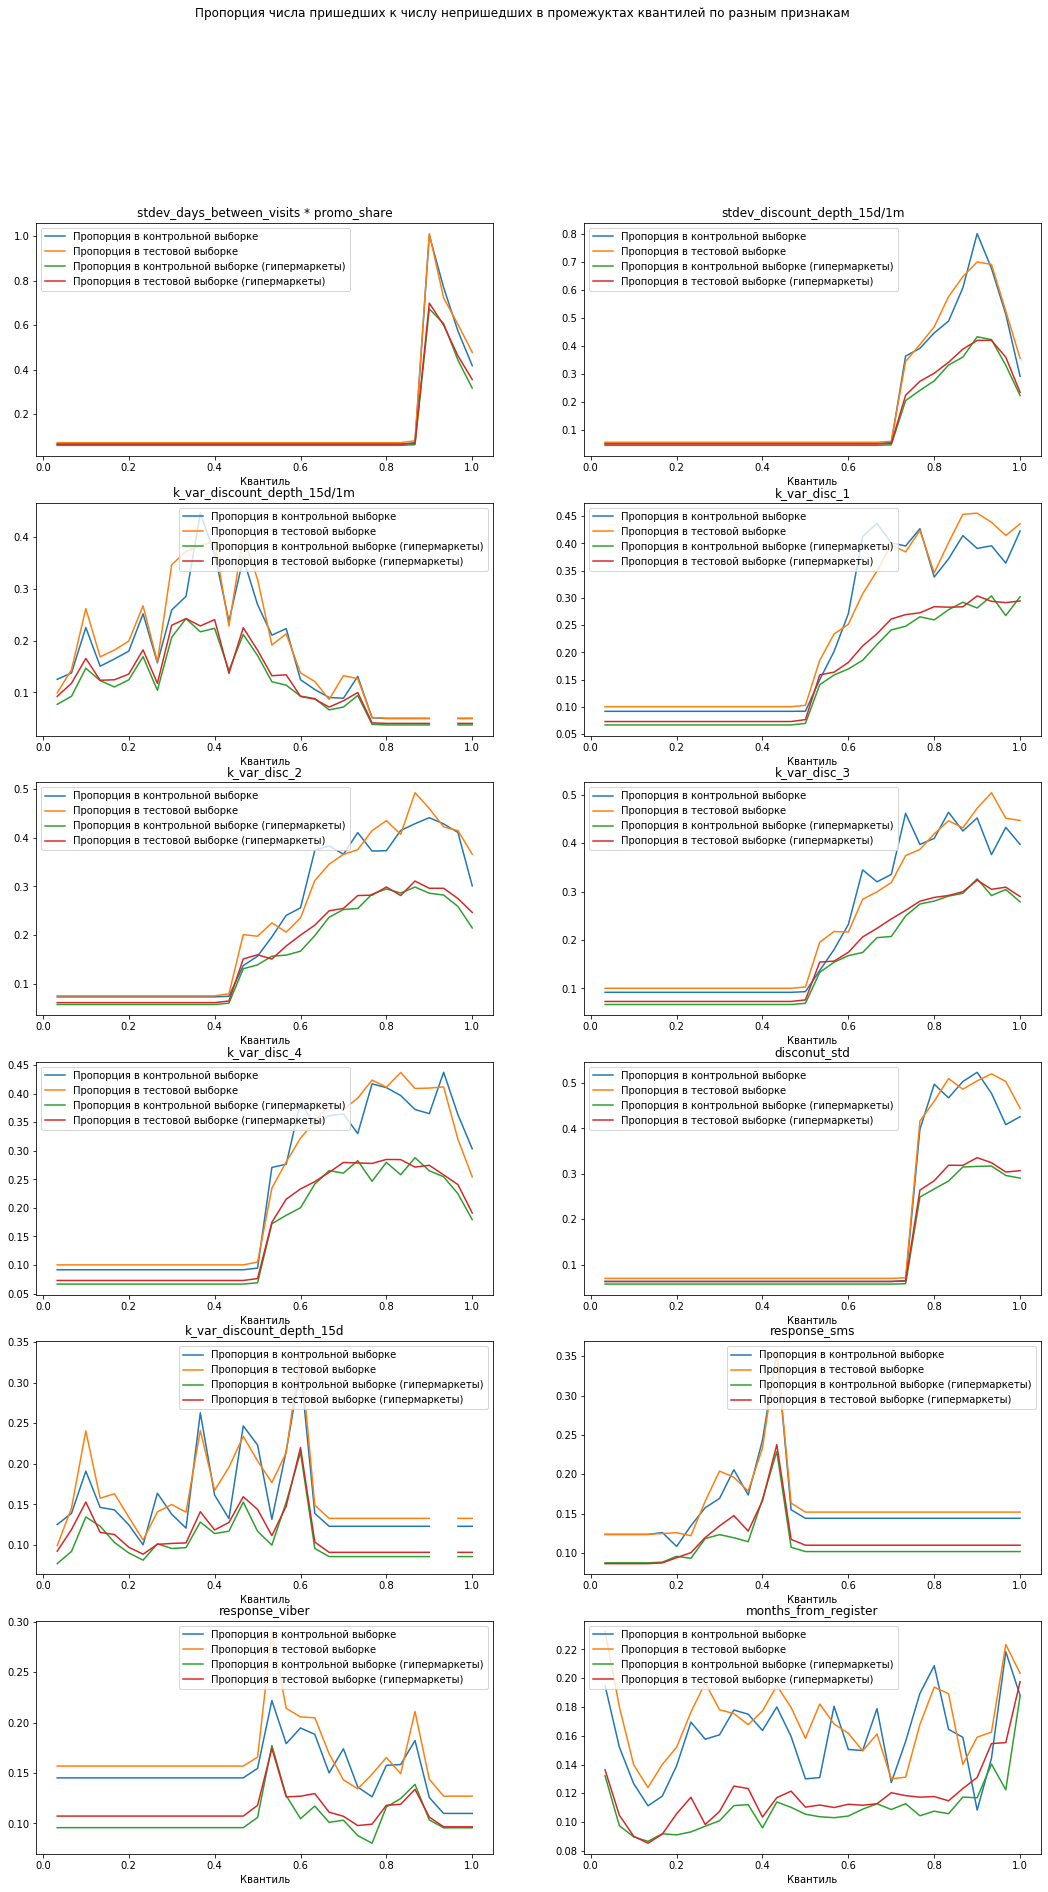

In [170]:
quantile_activeness_proportions(data, features_list, n_groups=30)

IndexError: index 3 is out of bounds for axis 0 with size 3

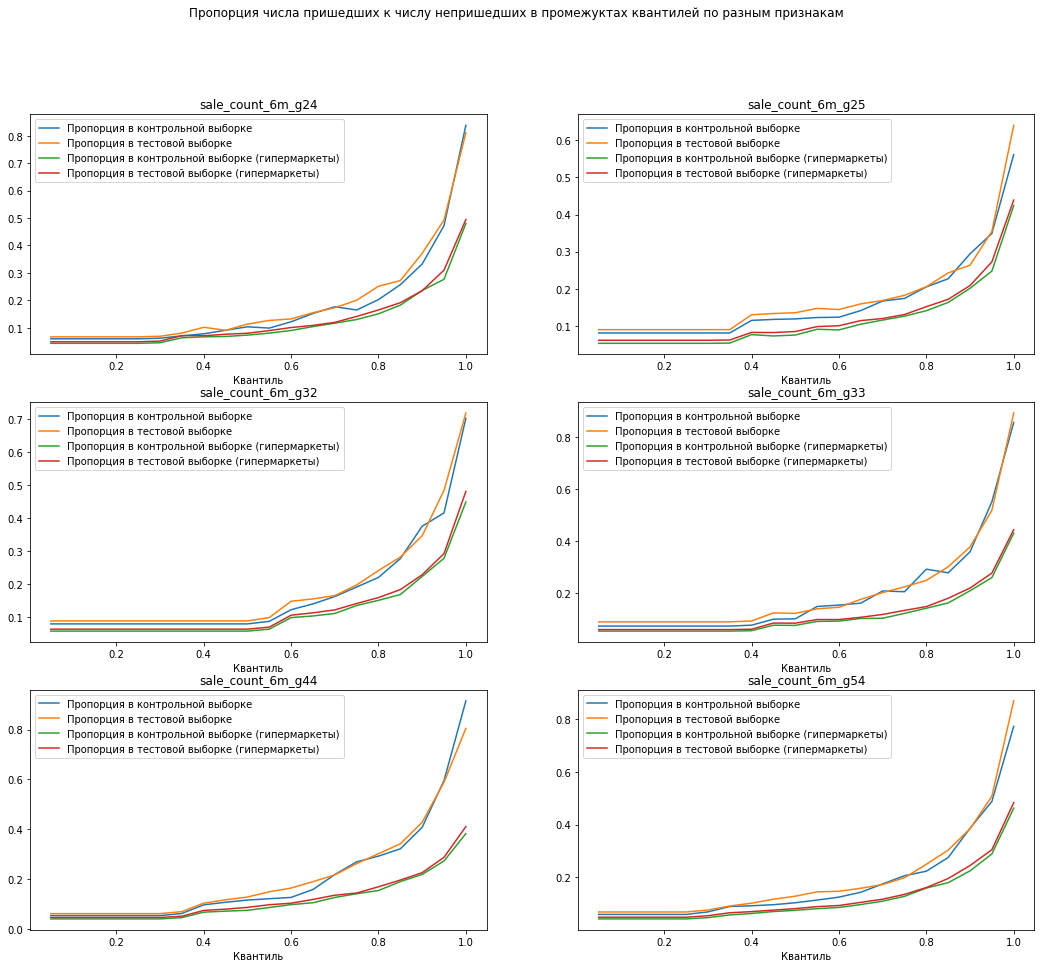

In [157]:
quantile_activeness_proportions(data, 
    get_columns_list(data, ["sale_count_6m_g{}".format(i) for i in all_groups]))

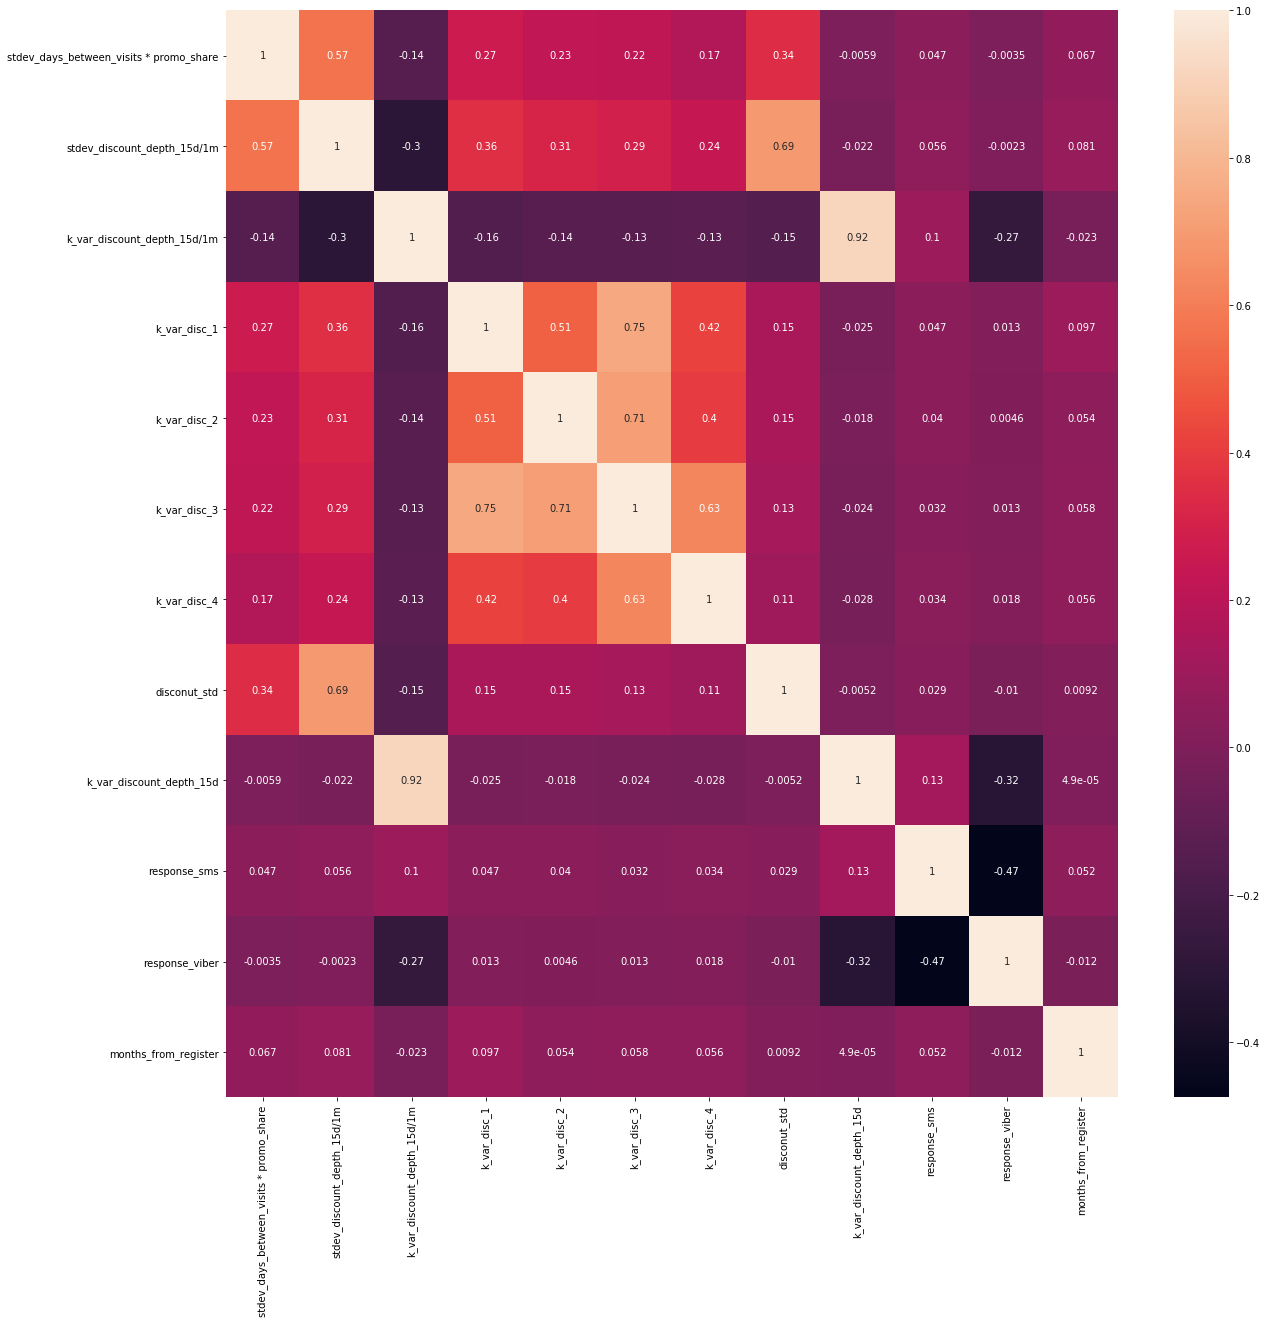

In [175]:
fig = plt.figure(figsize=(20, 20))
sns.heatmap(data[features_list].corr(), annot=True)
plt.show()

In [301]:
def magic_f(data, set_):
    a, b, c = set_
    return np.sqrt(data[a] **2 + data[b]**2 + data[c]**2)

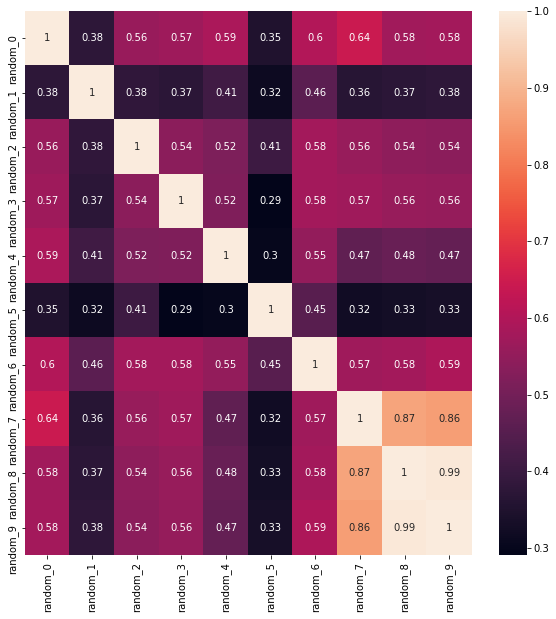

In [340]:
dic = {}
clmns = data.columns
for i in range(10):
    a, b, c  = np.random.choice(clmns, 3, replace=False)
    dic[i] = (a, b, c)
    
    temp = magic_f(data, (a, b, c))
    temp.loc[temp > temp.quantile(0.75)] = temp.mean()
    data['random_{}'.format(i)] = temp

fig = plt.figure(figsize=(10, 10))
sns.heatmap(data[['random_{}'.format(i) for i in range(10)]].corr(), annot=True)
plt.show()

data.drop(['random_{}'.format(i) for i in range(10)], axis=1, inplace=True)

In [350]:
e = (dic[8], dic[9])

In [351]:
e

(('sale_sum_6m_g44', 'sale_count_6m_g44', 'k_var_disc_share_6m_g54'),
 ('sale_sum_6m_g44',
  'cheque_count_6m_g20',
  'perdelta_days_between_visits_15_30d'))

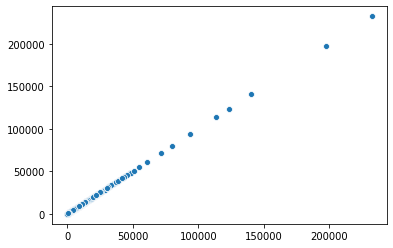

In [352]:
a1 = magic_f(data, e[0])
a2 = magic_f(data, e[1])
mask = (a2 <= a2.quantile(0.75)).values & (a1 <= a1.quantile(0.75)).values
sns.scatterplot(a1, a2)

In [323]:
sp = [
    (('stdev_discount_depth_1m', 'sale_count_12m_g54', 'k_var_disc_4'),
         ('sale_count_12m_g54', 'cheque_count_12m_g21', 'sale_count_12m_g57')), #0.93
    (('cheque_count_6m_g46', 'sale_sum_6m_g32', 'sale_sum_12m_g27'),
         ('k_var_cheque_15d', 'cheque_count_3m_g21', 'sale_sum_12m_g27')), #0.96
    (('k_var_disc_share_6m_g54', 'cheque_count_12m_g20', 'k_var_disc_share_6m_g24'),
         ('k_var_sku_price_3m_g27', 'k_var_sku_price_3m_g41', 'cheque_count_12m_g20')), #0.97
    (('cheque_count_6m_g45', 'sale_sum_6m_g33', 'stdev_discount_depth_1m'),
         ('sale_sum_6m_g33', 'k_var_disc_3', 'sale_count_6m_g32')),
    (('sale_sum_6m_g44', 'sale_count_6m_g44', 'k_var_disc_share_6m_g54'),
         ('sale_sum_6m_g44','cheque_count_6m_g20','perdelta_days_between_visits_15_30d'))
]

In [347]:
features_list = ['feature{}'.format(i) for i in range(len(sp)*2)]

for i in range(len(sp)*2):
    data.loc[:, 'feature{}'.format(i)] = magic_f(data, sp[i // 2][i % 2])

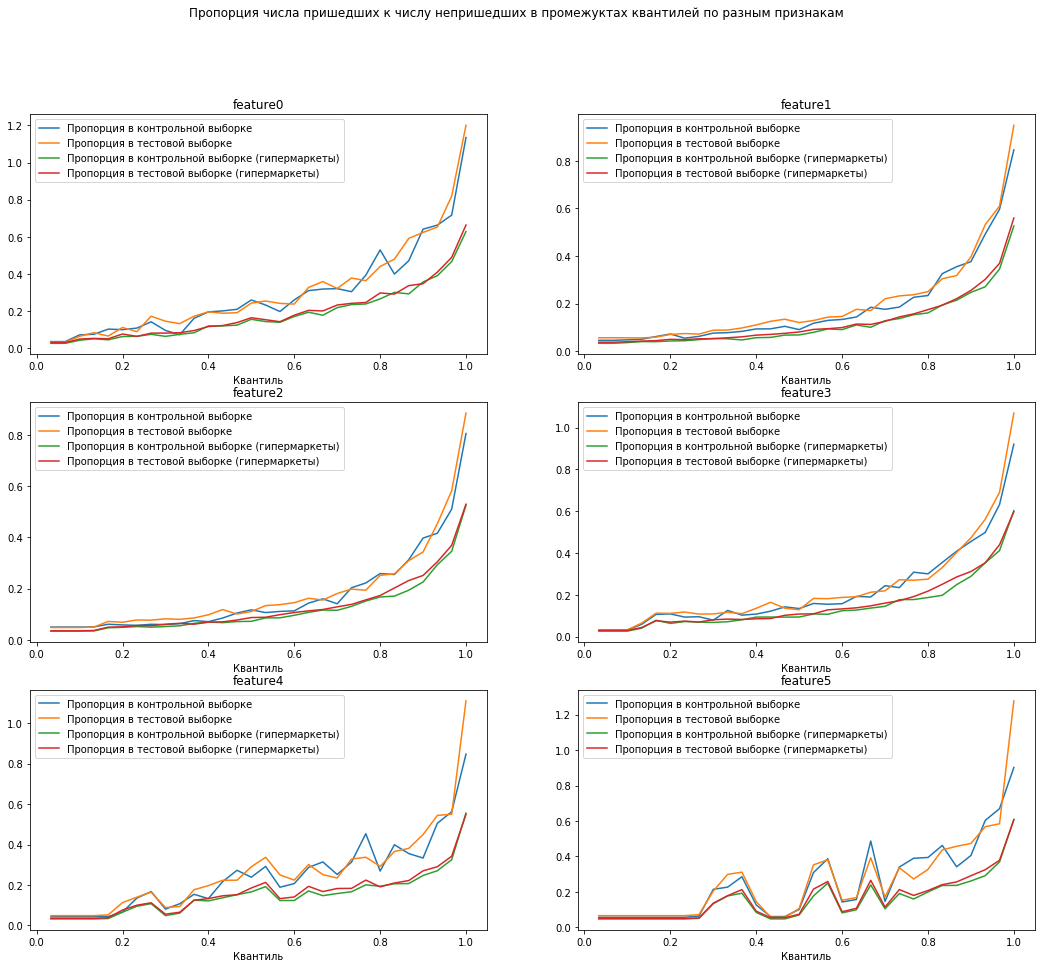

In [348]:
quantile_activeness_proportions(data, features_list, n_groups=30)

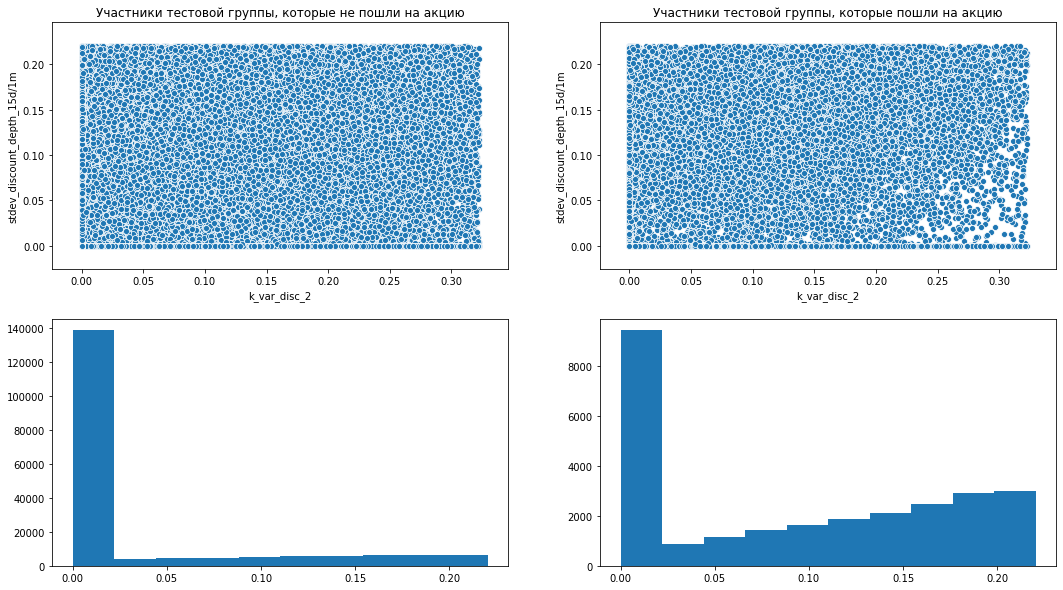

KeyboardInterrupt: 

In [334]:
for i in range(3):
    a, b = np.random.choice(features_list, 2, replace=False)
    separation_scatter(data, a, b, dropx=True, dropy=True)

Проверка матрицы корреляции не выявила какой-то особенной связи.

Ни один из проверенных параметров не дал полезного результата: разделяя по выбросам, мы обнаружили, что соотношение людей в тестовой и контрольной группе примерно одно и то же. Отделим выбросы и попытаемся (по whis=1.5) и продолжим поиски. 

In [12]:
# Separation parameter
whis = 1.5

data_map = np.array([])
# Cycle by chosen features
for key in list(collect_features.keys()) + add_features:
    
    # Drop outliers
    IQR = data[key].quantile(0.75) - data[key].quantile(0.25)
    
    if not data_map.size:
        data_map = (data[key] <= data[key].quantile(0.75) + IQR * whis).values
    else:
        data_map = data_map & (data[key] <= data[key].quantile(0.75) + IQR * whis).values
        
data = data[data_map]

## 2.2. Ошибки в данных

In [13]:
data.isna().any(axis=1).value_counts()

True     532384
False       393
dtype: int64

Таких строк очень мало, поэтому придётся как-то заполнять NaN. Если заполнять средними, то это слишком разрежено, поэтому будем заполнять для каждого индекса по-своему. Индекс - это определенные значения колон из "index_columns". Проблема в том, что и них встречаются NaN значения.

In [14]:
print("Чаще всего у покупателя",
      data['children'].value_counts().sort_values(ascending=False).index[0],
      "детей")

Чаще всего у покупателя 0.0 детей


In [15]:
index_columns = ['gender', 'main_format', 'children']

# Let's fill NaN in "index_columns"
data.loc[:, 'group'].replace({'test' : 1, 'control' : 0}, inplace=True)
data.loc[:,'gender'].replace({'М' : 2, 'Ж' : 1, 'Не определен' : 0, None : 0}, inplace=True)
data.loc[:,'children'].replace({None : -1}, inplace=True)

In [16]:
# Calculate percent of records with NaNs
def proportion(series):
    if (series.loc[False] == series.sum()):
        return 0
    return series.loc[True] / series.sum()

dataframe = {'name' : [], 'nans' : []}
for column in data.columns:
    dataframe['name'] += [column]
    dataframe['nans'] += [proportion(data[column].isna().value_counts())]

# Show top 5 by calculated percent
pd.DataFrame(dataframe).sort_values(ascending=False, by='nans')[:5]

,name,nans
120,k_var_sku_price_15d_g49,0.786162
85,k_var_disc_share_15d_g49,0.786042
62,k_var_count_per_cheque_15d_g34,0.736070
119,k_var_sku_price_15d_g34,0.736070
84,k_var_disc_share_15d_g34,0.735981


In [17]:
# Group mean values
group_means = data.groupby(index_columns).mean()
group_means.fillna(group_means.mean(), inplace=True)

for i in group_means.index:
        data.loc[(data['gender'] == i[0]).values &
                 (data['main_format'] == i[1]).values &
                 (data['children'] == i[2]).values] = data.loc[(data['gender'] == i[0]).values &
                     (data['main_format'] == i[1]).values &
                     (data['children'] == i[2]).values].fillna(group_means.loc[i])
        
# Deal with NaN values by groupes
for i in group_means.index:
    data.loc[(data['gender'] == i[0]).values &
             (data['main_format'] == i[1]).values &
             (data['children'] == i[2]).values] = data.loc[(data['gender'] == i[0]).values &
                                                           (data['main_format'] == i[1]).values &
                                                           (data['children'] == i[2]).values].fillna(group_means.loc[i])

# 3. Анализ

In [ ]:
data_granch = 

# 4. Поиск класса людей, которым требуется коммуникация
Общий ход действий такой: создадим побольше интерпретируемых признаков и сделаем вектор значений для каждого человека. После этого найдём всем людям из контрольной группы близжайшего по некоторой метрике партнера. Тогда для каждого человека будем знать его поведение как 1 из 4 классов: \
1) идет на акцию, только если с ним коммуницировать \
2) никогда не ходит на акцию \
3) всегда идет на акцию \
4) идет на акцию, только если с ним не коммуницировать

In [19]:
data = data[original_columns]
data.shape

(532777, 195)

Посмотрим на участников обеих подгрупп с точки зрения их признаков \
1. Сумма продаж товаров из доступных групп за 3 месяца
2. Отклик на предыдущие sms-рассылки

In [ ]:
# from scipy.linalg import svd

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==1].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

sample = data[data['group'] == 1]
sample = sample[sample['response_att']==0].fillna(0).drop('response_att', axis=1)
sample = (sample - data.drop('response_att', axis=1).mean())
U, s, Vh = svd(sample, full_matrices=False)
feature1 = (U @ np.diag(s))[:, 0]
feature2 = (U @ np.diag(s))[:, 1]
sns.scatterplot(feature1, feature2)

plt.show()